# Assignment 9: Cross Validation and Artificial Neural Networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import model_selection, ensemble

In [3]:
import autograd.numpy as anp
import autograd

In [4]:
from mls import locate_data, cv_summary

### Problem 1

The default score function used by sklearn to evaluate how well a regression model predicts data is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$. Implement the function below to calculate $R^2$:

In [5]:
def calculate_R2(y_data, y_pred):
    """Calculate the coefficient of determination R2 for two arrays.
    
    Parameters
    ----------
    y_data : array
        Array of data values, must have the same shape as y_pred.
    y_pred : array
        Array of predicted values, must have the same shape as y_data.
        
    Returns
    -------
    float
        Calculated coefficient of determination R2.
    """
    assert y_data.shape == y_pred.shape
    ### BEGIN SOLUTION
    y_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_mean) ** 2)
    SSres = np.sum((y_data - y_pred) ** 2)
    return 1. - SSres / SStot
    ### END SOLUTION

In [6]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N = 100
x = gen.uniform(size=N)
y_pred = 2 * x - 1
y_data = y_pred + gen.normal(scale=0.1, size=N)
assert np.round(calculate_R2(y_data, y_pred), 3) == 0.961
assert np.round(calculate_R2(y_data, -y_pred), 3) == -2.935
assert np.round(calculate_R2(y_pred, y_pred), 3) == 1.000
assert np.round(calculate_R2(y_pred, -y_pred), 3) == -3.000
assert np.round(calculate_R2(y_data, np.full(N, np.mean(y_pred))), 3) == 0.000

### Problem 2

Implement the function below to perform a [grid-search cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) of a [random forest regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) over the following grid:
 - `min_samples_leaf` = 1, 10, 20
 - `n_estimators` = 5, 10, 15
 
Hint: you will need to ensure reproducible "random" behavior in order to pass all the tests.

In [7]:
def cross_validate(X, Y, gen):
    """Perform cross validation of a random forest regression.
    
    Parameters
    ----------
    X : array
        Array with shape (N, DX) of N samples with DX features.
    Y : array
        Array with shape (N, DY) of N samples with DY features.
    gen : np.random.RandomState
        Random state to use for reproducible random numbers.
        
    Returns
    -------
    pandas.DataFrame
        Cross-validation summary table produced by cv_summary().
    """
    assert len(X) == len(Y)
    ### BEGIN SOLUTION
    cv = model_selection.GridSearchCV(
        ensemble.RandomForestRegressor(random_state=gen),
        {'min_samples_leaf': [1, 10, 20], 'n_estimators': [5, 10, 15]},
        cv=2, return_train_score=True)
    cv.fit(X, Y)
    return cv_summary(cv)
    ### END SOLUTION

In [8]:
X = pd.read_hdf(locate_data('spectra_data.hf5')).values
Y = pd.read_hdf(locate_data('spectra_targets.hf5')).values

In [9]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
cvs = cross_validate(X, Y, gen)
assert np.all(cvs.columns.values == [
    'mean_test', 'mean_train', 'min_samples_leaf', 'n_estimators', 'split0_test',
    'split0_train', 'split1_test', 'split1_train', 'std_test', 'std_train'])
assert np.all(cvs['min_samples_leaf'].values == [1, 1, 1, 10, 10, 10, 20, 20, 20])
assert np.all(cvs['n_estimators'].values == [15, 10, 5, 15, 10, 5, 15, 10, 5])
assert np.allclose(
    cvs['mean_test'].values,
    [0.962, 0.957, 0.944, 0.907, 0.904, 0.891, 0.610, 0.605, 0.593], atol=1e-3)
assert np.allclose(
    cvs['mean_train'].values,
    [0.994, 0.993, 0.991, 0.920, 0.920, 0.917, 0.621, 0.624, 0.615], atol=1e-3)

### Problem 3

In class, we hand-tuned a network to assign 2D points to the correct cluster, then repeated the exercise using tensorflow to automatically learn network parameters from the training data. In this problem, you will construct and optimize the same neural network by hand (without tensorflow) to get a deeper understanding of what is involved (and why tensorflow saves a lot of work).

First, load the training data:

In [10]:
X = pd.read_hdf(locate_data('circles_data.hf5')).values
y = pd.read_hdf(locate_data('circles_targets.hf5')).values.astype(np.float)

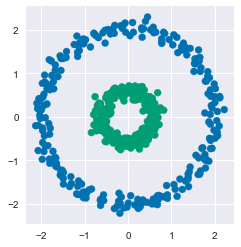

In [11]:
def plot_circles():
    cmap = sns.color_palette('colorblind', 2)
    colors = [cmap[int(c)] for c in y]
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.gca().set_aspect(1)
    
plot_circles()

Next, implement the function below to evalute the network prediction given its parameter values and a 2D input point $(x_1, x_2)$. Recall that the network consists of:
 - 2 input nodes
 - 4 hidden nodes with sigmoid activation
 - 1 output node with sigmoid activation
 
The corresponding mathematical function is:
$$
\begin{align}
y^{out}(\mathbf{x},\Theta)
&= \phi\left([u_1, u_2, u_3, u_4]\cdot \mathbf{G}(x_1, x_2) + a \right) \\
\mathbf{G}(x_1, x_2) &= \phi\left(
\begin{bmatrix}
v_{11} & v_{12} \\
v_{21} & v_{22} \\
v_{31} & v_{32} \\
v_{41} & v_{42}
\end{bmatrix} \cdot \begin{bmatrix}x_1 \\ x_2\end{bmatrix} +
\begin{bmatrix}b_1 \\ b_2 \\ b_3 \\ b_4\end{bmatrix}
\right)
\end{align} \\
\phi(s) = \frac{1}{1 + e^{-s}}
$$
In the function, we pack all the parameters into a single array to simplify the later steps.

In [12]:
def network(x, params):
    """Evaluate the network output at (x1,x2) with the specified parameters.
    
    Parameters
    ----------
    x : array
        Array of length 2 giving the 2D coordinates of a point to classify.
    params : array
        Array of length 17 containing values for the parameters: u1, u2, u3, u4, a,
        v11, v12, v21, v22, v31, v32, v41, v42, b1, b2, b3, b4.
        
    Returns
    -------
    float
        Value of the network's single output node.
    """
    ### BEGIN SOLUTION
    u1, u2, u3, u4, a, v11, v12, v21, v22, v31, v32, v41, v42, b1, b2, b3, b4 = params
    phi = lambda s: 1 / (1 + anp.exp(-s))
    V = anp.array([[v11, v12], [v21, v22], [v31, v32], [v41, v42]])
    B = anp.array([b1, b2, b3, b4])
    G = phi(anp.dot(V, x) + B)
    U = anp.array([u1, u2, u3, u4])
    return phi(anp.dot(U, G) + a)
    ### END SOLUTION

In [13]:
# A correct solution should pass the tests below.
initial = np.array([
    5,5,5,5,              # ui
    -18,                  # a
    8,0, -8,0, 0,8, 0,-8, # vij
    10,10,10,10           # bi
], dtype=float)
assert np.round(network([0, 0], initial), 3) == 0.881
assert np.round(network([0, 1], initial), 3) == 0.803
assert np.round(network([1, 0], initial), 3) == 0.803
assert np.round(network([1, -1], initial), 3) == 0.692
assert np.round(network([-1, 1], initial), 3) == 0.692

We can learn the parameters from the data by optimizing the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function:
$$
E(\Theta, \mathbf{X}^{train}, \mathbf{y}^{train}) =
-\sum_{i=1}^N\, \left[
y^{train}_i \log y^{out}(\mathbf{X}^{train}_i, \Theta) + (1 - y^{train}_i) \log (1 - y^{out}(\mathbf{X}^{train}_i, \Theta)) \right]
$$
(Refer to the Neural Network lecture notes for details on why this is a good loss function).

Implement the function below to evaluate this loss:

In [14]:
def loss(params, X_train, y_train):
    """Evaluate the cross-entropy loss.
    
    Parameters
    ----------
    params : array
        Array of length 17 containing values for the parameters: u1, u2, u3, u4, a,
        v11, v12, v21, v22, v31, v32, v41, v42, b1, b2, b3, b4.
    X_train : array
        Array of shape (N, 2) with training values.
    y_train : array
        Array of N target values which are each either 0. or 1.
        
    Returns
    -------
    float
        The cross-entropy loss value.
    """
    ### BEGIN SOLUTION
    y_out = anp.array([network(x, params) for x in X_train])
    y_train = y_train.reshape(-1)
    return -anp.sum(y_train * anp.log(y_out) + (1 - y_train) * anp.log(1 - y_out))
    ### END SOLUTION

In [15]:
# A correct solution should pass the tests below.
assert np.round(loss(initial, np.array([[0.,0.]]), np.array([0.])), 3) == 2.126
assert np.round(loss(initial, np.array([[0.,0.]]), np.array([1.])), 3) == 0.127
assert np.round(loss(initial, np.array([[2.,1.]]), np.array([0.])), 3) == 0.027
assert np.round(loss(initial, np.array([[2.,1.]]), np.array([1.])), 3) == 3.611
assert np.round(loss(initial, X, y), 1) == 41.4

We can check if the initial parameter values are at a local minimum of the loss by running 1D scans along each parameter axis. Scans are also useful for rough numerical estimates of the partial derivatives
$$
\frac{\partial}{\partial \Theta_k} E(\Theta, \mathbf{X}^{train}, \mathbf{y}^{train}) \; .
$$

numerical grad[u1] = -24.192
numerical grad[u2] = -24.182
numerical grad[u3] = -24.177
numerical grad[u4] = -24.121
numerical grad[a] = -21.982
numerical grad[v11] = -0.528
numerical grad[v12] = 0.005
numerical grad[v21] = 0.464
numerical grad[v22] = -0.048
numerical grad[v31] = -0.003
numerical grad[v32] = -0.538
numerical grad[v41] = -0.016
numerical grad[v42] = 0.453
numerical grad[b1] = 0.316
numerical grad[b2] = 0.262
numerical grad[b3] = 0.329
numerical grad[b4] = 0.266


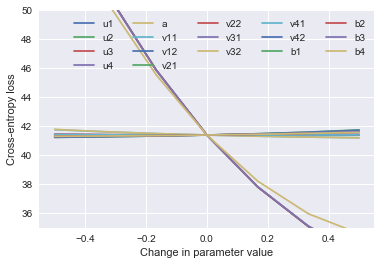

In [16]:
def plot_scans(params, X_train, y_train, step_size=0.5, n=3):
    names = 'u1,u2,u3,u4,a,v11,v12,v21,v22,v31,v32,v41,v42,b1,b2,b3,b4'.split(',')
    dp_grid = np.linspace(-step_size, +step_size, 2 * n + 1)
    L = np.empty_like(dp_grid)
    for i, p0 in enumerate(initial):
        pscan = params.copy()
        for j, dp in enumerate(dp_grid):
            pscan[i] = p0 + dp
            L[j] = loss(pscan, X_train, y_train)
        plt.plot(dp_grid, L, label=names[i])
        print('numerical grad[{}] = {:.3f}'.format(names[i], np.gradient(L, dp_grid)[n]))
    plt.legend(ncol=5)
    plt.ylim(35., 50.)
    plt.xlabel('Change in parameter value')
    plt.ylabel('Cross-entropy loss')

plot_scans(initial, X, y)

Finally, implement the function below to calculate the partial derivatives of the loss function,
$$
\frac{\partial}{\partial \Theta_k} E(\Theta, \mathbf{X}^{train}, \mathbf{y}^{train}) \; .
$$
These should be calculated to high accuracy, to allow stable optimization, so either using the autograd package for automatic differentiation (refer to the Optimization lecture) or else using derivative formulas that you calculate by hand.

In [17]:
def loss_gradient(params, X_train, y_train):
    """Calculate the partial derivatives of the loss function.
    
    Parameters
    ----------
    params : array
        Array of length 17 containing values for the parameters: u1, u2, u3, u4, a,
        v11, v12, v21, v22, v31, v32, v41, v42, b1, b2, b3, b4.
    X_train : array
        Array of shape (N, 2) with training values.
    y_train : array
        Array of N target values which are each either 0. or 1.
        
    Returns
    -------
    array
        Array of length 17 containing the partial derivatives of the loss function
        with respect to each of the parameters.
    """
    ### BEGIN SOLUTION
    return autograd.grad(loss)(params, X_train, y_train)
    ### END SOLUTION

In [18]:
# A correct solution should pass the tests below.
assert np.allclose(
    np.round(loss_gradient(initial, np.array([[0.,0.]]), np.array([0.])), 3),
    [ 0.881, 0.881, 0.881, 0.881, 0.881, 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0.], atol=1e-3)
assert np.allclose(
    np.round(loss_gradient(initial, np.array([[0.,0.]]), np.array([1.])), 3),
    [ -0.119, -0.119, -0.119, -0.119, -0.119, 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], atol=1e-3)
assert np.allclose(
    np.round(loss_gradient(initial, np.array([[2.,1.]]), np.array([0.])), 3),
    [ 0.027, 0., 0.027, 0.024, 0.027, 0., 0., 0.001,
      0., 0., 0., 0.028, 0.014, 0., 0., 0., 0.014], atol=1e-3)
assert np.allclose(
    np.round(loss_gradient(initial, np.array([[2.,1.]]), np.array([1.])), 3),
    [ -0.973, -0.002, -0.973, -0.857, -0.973, -0., -0., -0.024,
      -0.012, 0., 0., -1.022, -0.511, 0., -0.012, 0., -0.511], atol=1e-3)
assert np.allclose(
    np.round(loss_gradient(initial, X, y), 1),
    [ -24.1, -24.1, -24.1, -24.1, -21.9, -0.5, 0.0, 0.5, 0.0,
      0.0, -0.5, 0.0, 0.4, 0.3, 0.3, 0.3, 0.3 ], atol=1e-1)

You have now implemented all of the pieces necessary to optimize the 17 network parameters using the gradient descent update rule,
$$
\Theta \rightarrow \Theta - \eta \nabla E(\Theta) \; ,
$$
where $\eta$ is the learning rate.  The large values of some of the derivatives we found above indicate that $\eta$ will need to be small in order for the optimization to converge.

step 01: loss=38.8
step 02: loss=37.0
step 03: loss=35.6
step 04: loss=34.6
step 05: loss=33.8
step 06: loss=33.2
step 07: loss=32.8
step 08: loss=32.4
step 09: loss=32.2
step 10: loss=31.9
step 11: loss=31.8
step 12: loss=31.6
step 13: loss=31.5
step 14: loss=31.4
step 15: loss=31.4
step 16: loss=31.3
step 17: loss=31.2
step 18: loss=31.2
step 19: loss=31.1
step 20: loss=31.1


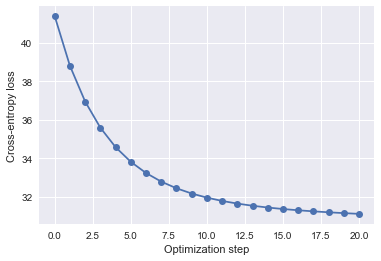

In [19]:
def optimize(initial, X_train, y_train, eta=0.001, n_steps=20):
    loss_history = [loss(initial, X_train, y_train)]
    params = initial.copy()
    for i in range(n_steps):
        params -= eta * loss_gradient(params, X_train, y_train)
        loss_history.append(loss(params, X_train, y_train))
        print('step {:02d}: loss={:.1f}'.format(i + 1, loss_history[-1]))
    plt.plot(loss_history, 'o-')
    plt.xlabel('Optimization step')
    plt.ylabel('Cross-entropy loss')

optimize(initial, X, y)